# Importing Libraries

In [84]:
import pandas as pd
import numpy as np 
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,confusion_matrix,classification_report
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import keras
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Basic EDA
Most of understanding was done using pandas profiling as it made really easy to understand the data.

In [2]:
df=pd.read_csv("../input/nasa-nearest-earth-objects/neo_v2.csv")

In [3]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [6]:
df.isnull().sum()

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [7]:
print(df["orbiting_body"].unique())
print(df['sentry_object'].unique())

['Earth']
[False]


Dropping columns id(high number of duplicates) ,name(too many categorical values),orbiting_body(single value) and sentry_object(single_value)  

In [8]:
df=df.drop(['id','name','orbiting_body','sentry_object'],axis=1)

In [9]:
le=LabelEncoder()
df['hazardous']=le.fit_transform(df['hazardous'])

In [10]:
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


<AxesSubplot:>

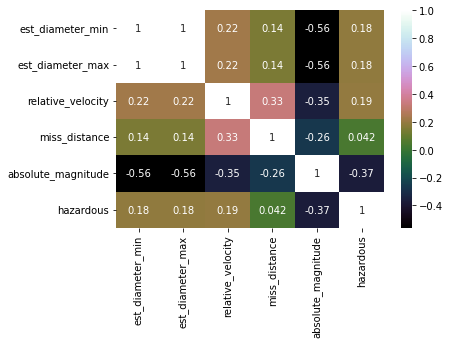

In [11]:
sns.heatmap(df.corr(), annot = True,cmap="cubehelix")

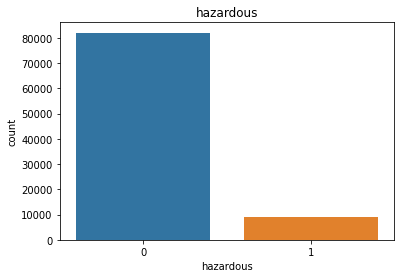

In [12]:
sns.countplot(df['hazardous'])
plt.title('hazardous')
plt.show()

<AxesSubplot:xlabel='est_diameter_max'>

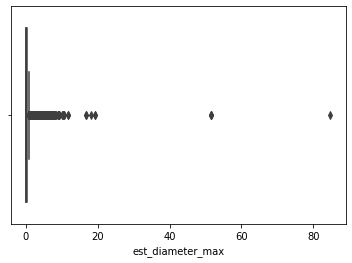

In [13]:
sns.boxplot(df['est_diameter_max'])

<AxesSubplot:xlabel='relative_velocity'>

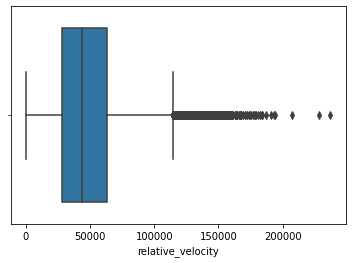

In [14]:
sns.boxplot(df['relative_velocity'])

<AxesSubplot:xlabel='miss_distance'>

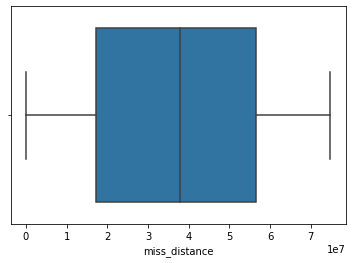

In [15]:
sns.boxplot(df['miss_distance'])

<AxesSubplot:xlabel='absolute_magnitude'>

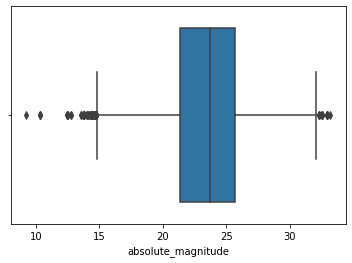

In [16]:
sns.boxplot(df['absolute_magnitude'])

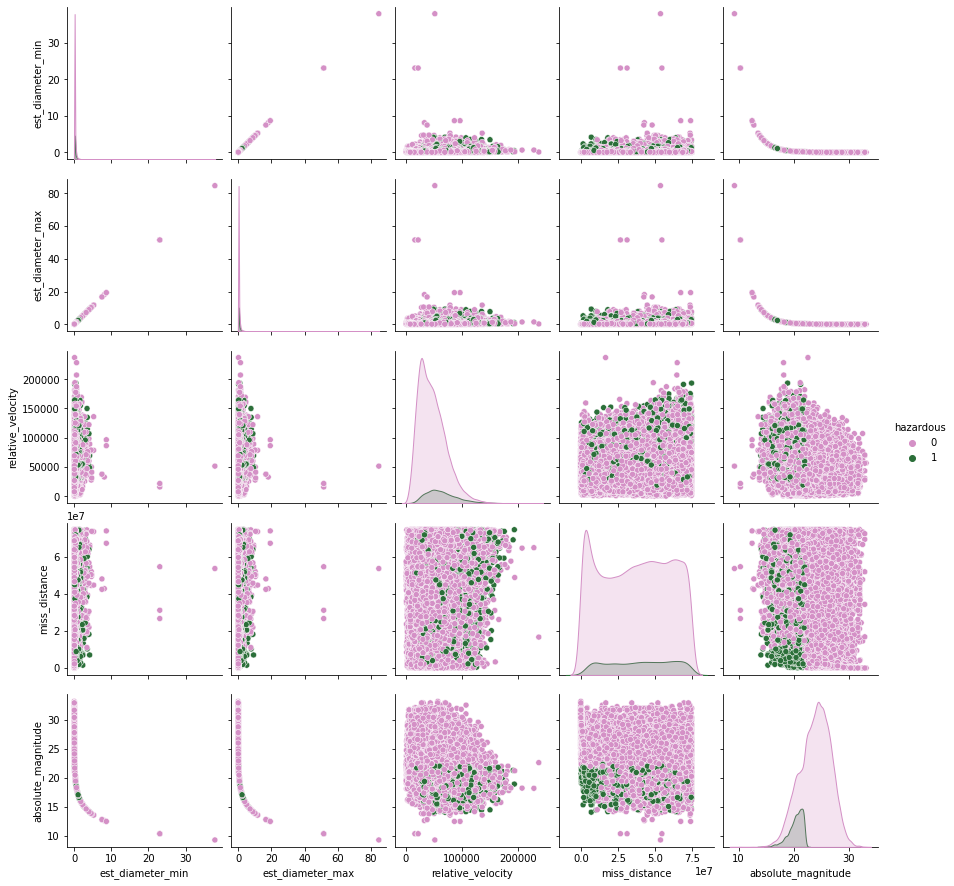

In [17]:
sns.pairplot(df,hue = 'hazardous',palette="cubehelix_r" )

Tried removing outliers but results worsened.

In [18]:
"""Q1=np.percentile(df['est_diameter_max'],25)
Q3=np.percentile(df['est_diameter_max'],75)
IQR=Q3-Q1
ul=Q3+1.5*IQR
ll=Q1-1.5*IQR
df=df[(df['est_diameter_max']<=ul) & (df['est_diameter_max']>=ll)]
df=df.reset_index(drop=True)"""

"Q1=np.percentile(df['est_diameter_max'],25)\nQ3=np.percentile(df['est_diameter_max'],75)\nIQR=Q3-Q1\nul=Q3+1.5*IQR\nll=Q1-1.5*IQR\ndf=df[(df['est_diameter_max']<=ul) & (df['est_diameter_max']>=ll)]\ndf=df.reset_index(drop=True)"

In [19]:
X=df.drop(['hazardous'],axis=1)

In [20]:
y=pd.DataFrame(df.hazardous)

As the target value is highly imbalanced tried using smote but doesn't help as the data is limited. But in case of real world we should try to use SMOTE or Nearmiss.

In [21]:
sm=SMOTE()
X,y=sm.fit_resample(X,y)

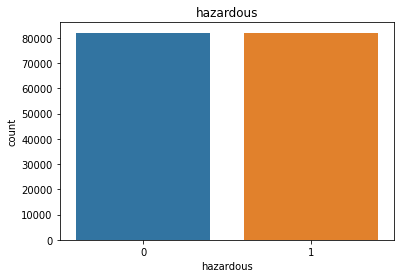

In [22]:
sns.countplot(y['hazardous'])
plt.title('hazardous')
plt.show()

In [23]:
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

# Splitting Data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
gc.collect()

56428

In [85]:
class CFG:
    epochs=50
    activation="relu"
    optimizer=optimizers.Adam()
    batch_size=128

In [86]:
model = models.Sequential()
model.add(layers.Dense(128, activation=CFG.activation, input_shape=(X_train.shape[1], )))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation=CFG.activation))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation=CFG.activation))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))


In [87]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               768       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_23 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [88]:
lr = keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5,patience=5, verbose=True)
es = keras.callbacks.EarlyStopping(monitor="val_auc", patience=8,verbose=True, mode="max",restore_best_weights=True)

In [89]:
model.compile(optimizer=CFG.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=CFG.epochs, batch_size=CFG.batch_size, validation_data=(X_test, y_test),callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),lr,es])

Epoch 1/50
897/897 [==============================] - 4s 4ms/step - loss: 0.3223 - accuracy: 0.8709 - val_loss: 0.2937 - val_accuracy: 0.8800
Epoch 2/50
897/897 [==============================] - 3s 3ms/step - loss: 0.2929 - accuracy: 0.8809 - val_loss: 0.2891 - val_accuracy: 0.8813
Epoch 3/50
897/897 [==============================] - 3s 3ms/step - loss: 0.2869 - accuracy: 0.8824 - val_loss: 0.2818 - val_accuracy: 0.8821
Epoch 4/50
897/897 [==============================] - 3s 4ms/step - loss: 0.2810 - accuracy: 0.8830 - val_loss: 0.2716 - val_accuracy: 0.8823
Epoch 5/50
897/897 [==============================] - 4s 4ms/step - loss: 0.2734 - accuracy: 0.8830 - val_loss: 0.2630 - val_accuracy: 0.8826
Epoch 6/50
897/897 [==============================] - 3s 3ms/step - loss: 0.2674 - accuracy: 0.8837 - val_loss: 0.2581 - val_accuracy: 0.8824
Epoch 7/50
897/897 [==============================] - 3s 4ms/step - loss: 0.2626 - accuracy: 0.8837 - val_loss: 0.2545 - val_accuracy: 0.8834
Epoch 

In [90]:
model.evaluate(X_test, y_test)

1538/1538 [==============================] - 3s 2ms/step - loss: 0.2320 - accuracy: 0.8840


[0.231965109705925, 0.8839993476867676]

In [91]:
history_list=history.history

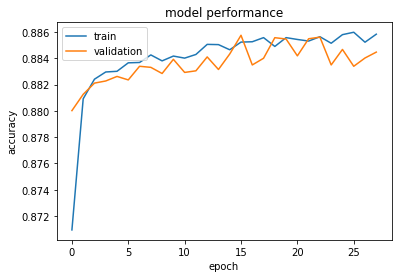

In [92]:
plt.plot(history_list["accuracy"])
plt.plot(history_list["val_accuracy"])
plt.title("model performance")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()